In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
import gc
from scipy.stats import zscore
from scipy.signal import detrend
import copy
import sys
from scipy.integrate import simpson as simps
from nice.algorithms.connectivity_AT import *
import mne
import warnings
warnings.filterwarnings("ignore")

# def preprocess(data):
#     data = detrend(data, axis=0)
#     epsilon = 1e-9
#     data = (data - np.mean(data, axis=0)) / (np.std(data, axis=0) + epsilon)
    
#     return data

def preprocess(data):
    stds = np.std(data[:, :], axis=0)
    non_constant_cols = stds > 1e-6
    if len(non_constant_cols) != 0:
        print('non constant column at ', np.where(non_constant_cols == False))
              
   
    constant_cols = stds < 1e-6

    z = np.zeros_like(data[:, :])
    z[:, non_constant_cols] = zscore(data[:, non_constant_cols], axis=0)
    z[:, constant_cols] = np.mean(data[:, constant_cols], axis = 0)

    #unsure what to replace lost values with, for now replacing with 0

    if np.isnan(z).any():
        raise ValueError("Data contains NaN values after normalization.")

    return z


file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]

wsmi_means = {f'dataset_{file_number}': {'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []} for file_number in file_numbers}
wsmi_AT = {f'dataset_{file_number}': {'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []} for file_number in file_numbers}
wsmi_stdevs = {f'dataset_{file_number}': {'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []} for file_number in file_numbers}

total_time = time.time()
for file_number in  file_numbers:
    file_total = time.time()
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    load_data_start_time = time.time()
    data = pickle.load(open(file_path, 'rb'))
    elapsed_time = time.time() - load_data_start_time
    print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")

    attention_labels = data['label_attend'][0]
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data["omit"][0]
    relevant = np.where(omitted == 0)[0]    #indices of agg where not omitted

    left_input_LFP = preprocess(data['LFP'][0][0][relevant])
    right_input_LFP = preprocess(data['LFP'][0][1][relevant])
    attention_LFP = preprocess(data['LFP_rec'][0][2][relevant])


    left_indices_agg = np.where((omitted ==0) & (attend_01 == 0))[0]  #indices of agg where left
    _, left_indices, _ = np.intersect1d(relevant, left_indices_agg, return_indices=True)   #indices for relevant processed data where attention left
    right_indices_agg = np.where((omitted ==0) & (attend_01 == 1))[0]
    _, right_indices, _ = np.intersect1d(relevant, right_indices_agg, return_indices=True)
    
    print(left_indices[0:10])
    print(right_indices[0:10])
    #print(f' found data for left {class_left}, right {class_right}')
    left_input_LFP_attleft = left_input_LFP[left_indices, 100:350]
    right_input_LFP_attleft = right_input_LFP[left_indices, 100:350]
    attention_LFP_attleft = attention_LFP[left_indices, 100:350]

    left_input_LFP_attright = left_input_LFP[right_indices, 100:350]
    right_input_LFP_attright = right_input_LFP[right_indices, 100:350]
    attention_LFP_attright = attention_LFP[right_indices, 100:350]

    #---------------------------------formatting for wsmi calculation------------------------------
    n_times = left_input_LFP_attleft.shape[1] ##=250
    print("n_samples", n_times)

    dt = 0.002
    sfreq = 1 / dt

    ch_names = ['left_input', 'right_input', 'attention_layer']
    ch_types = ['eeg', 'eeg', 'eeg']
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)


    #reshaping data for attention left
    raw_data_left = np.concatenate([
        left_input_LFP_attleft, 
        right_input_LFP_attleft, 
        attention_LFP_attleft 
    ], axis=0)  # Concatenate along time axis

    print("raw_data_left shape =", raw_data_left.shape)  
    # Reshape into (n_channels, n_samples)
    raw_data_left = raw_data_left.reshape(3, -1)  
    print('raw data left reshaped =', raw_data_left.shape) 
    raw_left = mne.io.RawArray(raw_data_left, info)
    print("raw_data_left =", raw_left)
    

    #reshaping date for attention right 
    raw_data_right = np.concatenate([
        left_input_LFP_attright,
        right_input_LFP_attright,
        attention_LFP_attright 
    ], axis=0)

    raw_data_right = raw_data_right.reshape(3, -1)
    raw_right = mne.io.RawArray(raw_data_right, info)


    #defininf event objects, arrays like [0,0,1], [250, 0, 1], [750, 0, 1] etc
    events_left = np.array([[i * n_times, 0, 1] for i in range(len(left_input_LFP_attleft))])
    events_right = np.array([[i * n_times, 0, 1] for i in range(len(left_input_LFP_attright))])

    
    print("events_left", events_left[:4])

    epochs_left = mne.Epochs(raw_left, events_left, event_id={'Trial': 1}, tmin=0, tmax =  0.498,  baseline=None, preload=True)
    epochs_right = mne.Epochs(raw_right, events_right, event_id={'Trial': 1}, tmin=0, tmax = 0.498, baseline=None, preload=True)
    print('----------------', (n_times - 1)/ sfreq)

    print("epochs_left", epochs_left)
    #epochs_left.plot(n_epochs=5, n_channels=3, scalings = 'auto', title="Attention Left")
    #plt.show()

    kernel = 3
    taus = [8, 16, 32, 64]  # in ms
    wsmi_results = {'left': {}, 'right': {}}
    wsmi_AT_results = {'left': {}, 'right': {}}

    for tau in taus:
        tau_samples = int(tau / (1000 / sfreq))
        print(f"tau_samples for {tau}: {tau_samples}")
        wsmi_left, smi_left, sym_left, count_left, pxy_track_left, wsmi_AT_left, smi_AT_left, pxy_track_AT_left = epochs_compute_wsmi(
            epochs_left, kernel=kernel, tau=tau_samples, backend='python', method_params={'bypass_csd': True}, 
        )
        wsmi_results['left'][tau] = wsmi_left
        wsmi_AT_results['left'][tau] = wsmi_AT_left
        #this containts the data for wsmi at a given tau given attending left. 

        wsmi_right, smi_right, sym_right, count_right, pxy_track_right, wsmi_AT_right, smi_AT_right, pxy_track_AT_right = epochs_compute_wsmi(
            epochs_right, kernel=kernel, tau=tau_samples, backend='python', method_params={'bypass_csd': True}, 
        )
        wsmi_results['right'][tau] = wsmi_right
        wsmi_AT_results['right'][tau] = wsmi_AT_right


    for tau in taus:
        wsmi_means[f'dataset_{file_number}']['left_attleft'].append(np.mean(wsmi_results['left'][tau][0, 2, :]))
        wsmi_means[f'dataset_{file_number}']['right_attleft'].append(np.mean(wsmi_results['left'][tau][1, 2, :]))
        wsmi_means[f'dataset_{file_number}']['left_attright'].append(np.mean(wsmi_results['right'][tau][0, 2, :]))
        wsmi_means[f'dataset_{file_number}']['right_attright'].append(np.mean(wsmi_results['right'][tau][1, 2, :]))

        wsmi_AT[f'dataset_{file_number}']['left_attleft'].append(wsmi_AT_results['left'][tau][0, 2])
        wsmi_AT[f'dataset_{file_number}']['right_attleft'].append(wsmi_AT_results['left'][tau][1, 2])
        wsmi_AT[f'dataset_{file_number}']['left_attright'].append(wsmi_AT_results['right'][tau][0, 2])
        wsmi_AT[f'dataset_{file_number}']['right_attright'].append(wsmi_AT_results['right'][tau][1, 2])

        wsmi_stdevs[f'dataset_{file_number}']['left_attleft'].append(np.std(wsmi_results['left'][tau][0, 2, :], ddof = 1))
        wsmi_stdevs[f'dataset_{file_number}']['right_attleft'].append(np.std(wsmi_results['left'][tau][1, 2, :], ddof = 1))
        wsmi_stdevs[f'dataset_{file_number}']['left_attright'].append(np.std(wsmi_results['right'][tau][0, 2, :], ddof = 1))
        wsmi_stdevs[f'dataset_{file_number}']['right_attright'].append(np.std(wsmi_results['right'][tau][1, 2, :], ddof = 1))

  
    del left_input_LFP_attleft, right_input_LFP_attleft, attention_LFP_attleft, left_input_LFP_attright, right_input_LFP_attright, attention_LFP_attright
    gc.collect()
    del(data)
    gc.collect()
    print(f'Dataset {file_number} complete in', time.time() - file_total)

print('total time elapsed =', time.time() - total_time)


Dataset 1 loaded in 28.14 seconds
non constant column at  (array([0]),)
non constant column at  (array([0]),)
non constant column at  (array([0, 1, 2, 3, 4, 5, 6, 7]),)
[ 0  1  2  6  9 10 11 12 13 14]
[ 3  4  5  7  8 15 18 20 21 22]
n_samples 250
raw_data_left shape = (1485, 250)
raw data left reshaped = (3, 123750)
Creating RawArray with float64 data, n_channels=3, n_times=123750
    Range : 0 ... 123749 =      0.000 ...   247.498 secs
Ready.
raw_data_left = <RawArray | 3 x 123750 (247.5 s), ~2.8 MB, data loaded>
Creating RawArray with float64 data, n_channels=3, n_times=140500
    Range : 0 ... 140499 =      0.000 ...   280.998 secs
Ready.
events_left [[  0   0   1]
 [250   0   1]
 [500   0   1]
 [750   0   1]]
Not setting metadata
Not setting metadata
495 matching events found
No baseline correction applied
0 projection items activated
Loading data for 495 events and 250 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
562 matching events found

{'8': [np.float64(0.029831908434272948), np.float64(0.03139583276971614), np.float64(0.031071627456489875), np.float64(0.03204894309450044), np.float64(0.030598378323713232), np.float64(0.03135158718800781), np.float64(0.030732117005441602), np.float64(0.03217228725812063)], '16': [np.float64(0.05575739686478369), np.float64(0.0558727797667105), np.float64(0.06091426673810073), np.float64(0.057735644719860056), np.float64(0.0588767308445089), np.float64(0.05672255131500984), np.float64(0.05636478189255282), np.float64(0.057284683481986814)], '32': [np.float64(0.10674023658914439), np.float64(0.10428089202266408), np.float64(0.1076131163663763), np.float64(0.10519709855240103), np.float64(0.11523456717915385), np.float64(0.11536833860397455), np.float64(0.1153328510380709), np.float64(0.11324119293503002)], '64': [np.float64(0.19278205204762924), np.float64(0.16931150303197046), np.float64(0.1781247941932189), np.float64(0.18715040718227283), np.float64(0.1863191458663197), np.float64(0

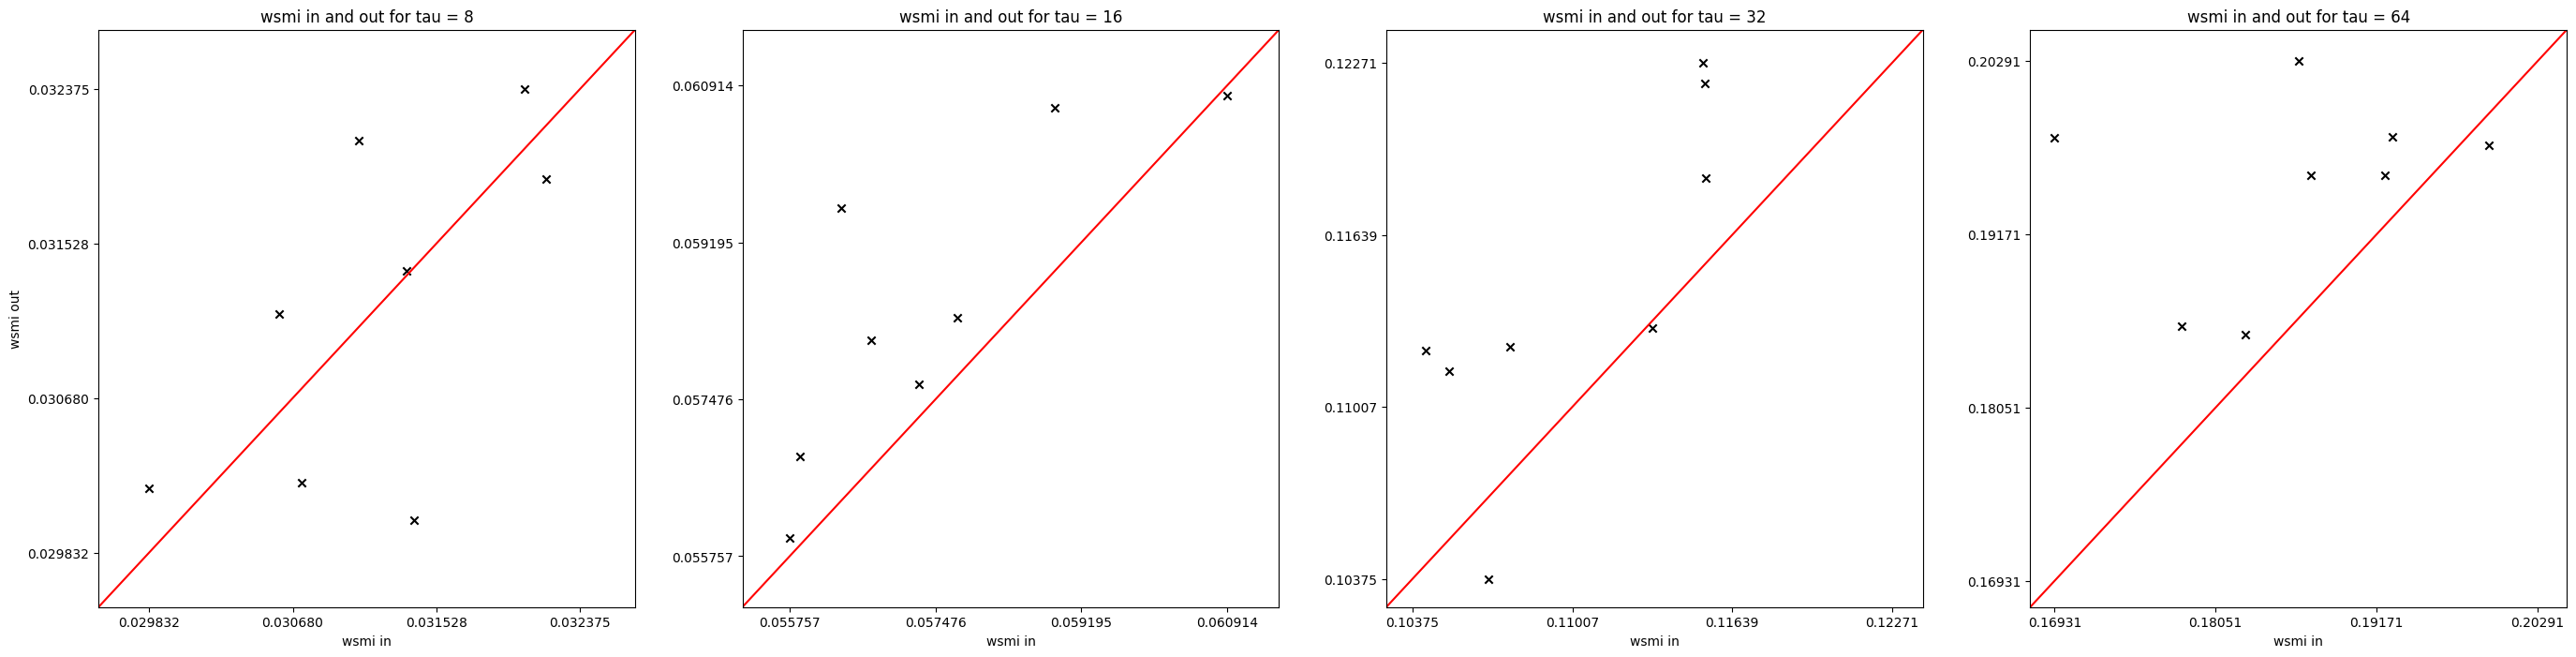

In [ ]:
taus = [8, 16, 32, 64]

wsmi_in = {f'{tau}': [] for tau in taus}
wsmi_out = {f'{tau}': [] for tau in taus}
errors_in = {f'{tau}': [] for tau in taus}
errors_out = {f'{tau}': [] for tau in taus}

for file_number in file_numbers:
    for tau, i in zip(taus, range(4)):
        #in
        values = [wsmi_means[f'dataset_{file_number}']['left_attleft'][i],
                  wsmi_means[f'dataset_{file_number}']['right_attright'][i]]
        errors = [wsmi_stdevs[f'dataset_{file_number}']['left_attleft'][i],
                  wsmi_stdevs[f'dataset_{file_number}']['right_attright'][i]]
        wsmi_in[f'{tau}'].append(np.mean(values))
        errors_in[f'{tau}'].append(np.mean(errors))
        
        #out
        values = [wsmi_means[f'dataset_{file_number}']['left_attright'][i],
                  wsmi_means[f'dataset_{file_number}']['right_attleft'][i]]
        errors = [wsmi_stdevs[f'dataset_{file_number}']['left_attright'][i],
                  wsmi_stdevs[f'dataset_{file_number}']['right_attleft'][i]]
        wsmi_out[f'{tau}'].append(np.mean(values))
        errors_out[f'{tau}'].append(np.mean(errors))

print(wsmi_in)
max_values = {}
min_values = {}

for tau in taus:
    all_vals = wsmi_in[f'{tau}'] + wsmi_out[f'{tau}']
    max_values[f'{tau}'] = max(all_vals)
    min_values[f'{tau}'] = min(all_vals)


fig, axs = plt.subplots(1,4, figsize=(34, 8))
for i, tau in enumerate(taus):
    axs[i].scatter(wsmi_in[f'{tau}'], wsmi_out[f'{tau}'], marker = 'x', color='k')
    axs[i].plot([0, 1], [0, 1], transform=axs[i].transAxes, color='r')
    axs[i].set_xlim(min_values[f'{tau}'] * 0.99, max_values[f'{tau}'] * 1.01)
    axs[i].set_ylim(min_values[f'{tau}'] * 0.99, max_values[f'{tau}'] * 1.01)
    axs[i].set_xticks(np.linspace(min_values[f'{tau}'], max_values[f'{tau}'], 4))
    axs[i].set_yticks(np.linspace(min_values[f'{tau}'], max_values[f'{tau}'], 4))
    axs[i].set_xlabel('wsmi in')
    axs[0].set_ylabel('wsmi out')
    axs[i].set_title(f'wsmi in and out for tau = {taus[i]}')
plt.show()


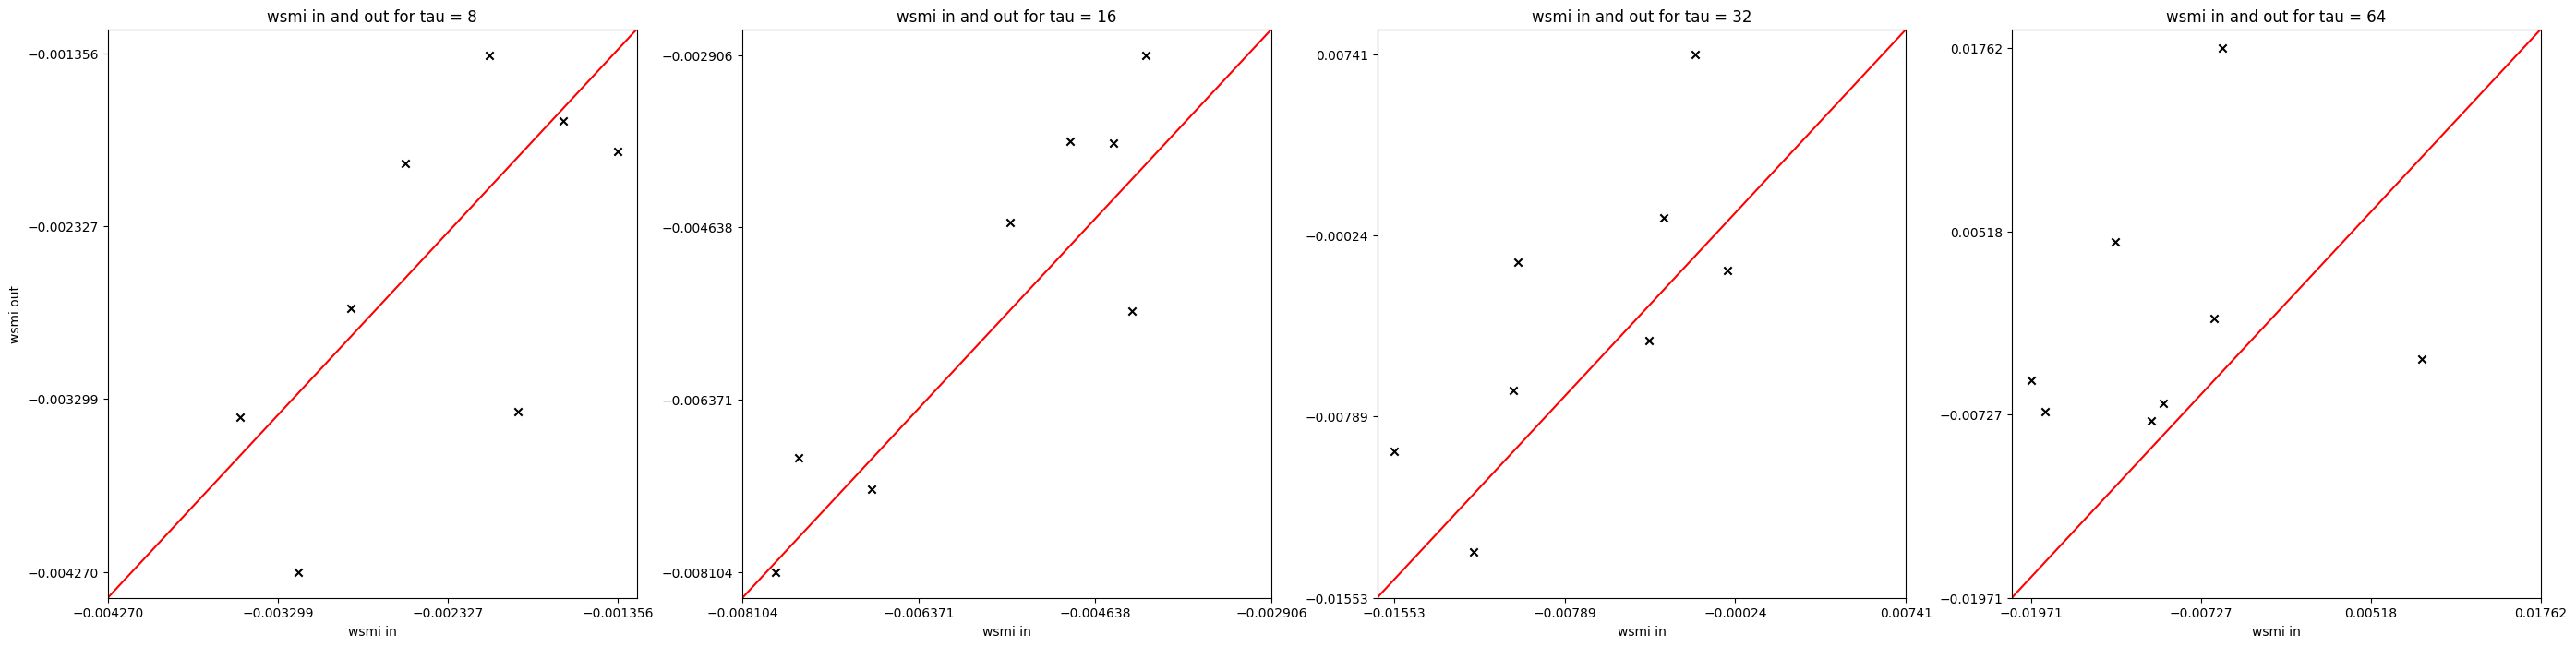

In [43]:
taus = [8, 16, 32, 64]

wsmi_AT_in = {f'{tau}': [] for tau in taus}
wsmi_AT_out = {f'{tau}': [] for tau in taus}

for file_number in file_numbers:
    for tau, i in zip(taus, range(4)):
        # IN: within-attended side
        values_in = [wsmi_AT[f'dataset_{file_number}']['left_attleft'][i],
                     wsmi_AT[f'dataset_{file_number}']['right_attright'][i]]
        wsmi_AT_in[f'{tau}'].append(np.mean(values_in))
        
        # OUT: across-attended side
        values_out = [wsmi_AT[f'dataset_{file_number}']['left_attright'][i],
                      wsmi_AT[f'dataset_{file_number}']['right_attleft'][i]]
        wsmi_AT_out[f'{tau}'].append(np.mean(values_out))

# Compute max/min for axis scaling
max_values = {f'{tau}': max(wsmi_AT_in[f'{tau}'] + wsmi_AT_out[f'{tau}']) for tau in taus}
min_values = {f'{tau}': min(wsmi_AT_in[f'{tau}'] + wsmi_AT_out[f'{tau}']) for tau in taus}

fig, axs = plt.subplots(1,4, figsize=(34, 8))
for i, tau in enumerate(taus):
    axs[i].scatter(wsmi_AT_in[f'{tau}'], wsmi_AT_out[f'{tau}'], marker = 'x', color='k')
    axs[i].plot([0, 1], [0, 1], transform=axs[i].transAxes, color='r')
    axs[i].set_xticks(np.linspace(min_values[f'{tau}'], max_values[f'{tau}'], 4))
    axs[i].set_yticks(np.linspace(min_values[f'{tau}'], max_values[f'{tau}'], 4))
    axs[i].set_xlabel('wsmi in')
    axs[0].set_ylabel('wsmi out')
    axs[i].set_title(f'wsmi in and out for tau = {taus[i]}')
plt.show()
